
# Single estimator versus bagging: bias-variance decomposition

This example illustrates and compares the bias-variance decomposition of the
expected mean squared error of a single estimator against a bagging ensemble.

In regression, the expected mean squared error of an estimator can be
decomposed in terms of bias, variance and noise. On average over datasets of
the regression problem, the bias term measures the average amount by which the
predictions of the estimator differ from the predictions of the best possible
estimator for the problem (i.e., the Bayes model). The variance term measures
the variability of the predictions of the estimator when fit over different
instances LS of the problem. Finally, the noise measures the irreducible part
of the error which is due the variability in the data.

The upper left figure illustrates the predictions (in dark red) of a single
decision tree trained over a random dataset LS (the blue dots) of a toy 1d
regression problem. It also illustrates the predictions (in light red) of other
single decision trees trained over other (and different) randomly drawn
instances LS of the problem. Intuitively, the variance term here corresponds to
the width of the beam of predictions (in light red) of the individual
estimators. The larger the variance, the more sensitive are the predictions for
`x` to small changes in the training set. The bias term corresponds to the
difference between the average prediction of the estimator (in cyan) and the
best possible model (in dark blue). On this problem, we can thus observe that
the bias is quite low (both the cyan and the blue curves are close to each
other) while the variance is large (the red beam is rather wide).

The lower left figure plots the pointwise decomposition of the expected mean
squared error of a single decision tree. It confirms that the bias term (in
blue) is low while the variance is large (in green). It also illustrates the
noise part of the error which, as expected, appears to be constant and around
`0.01`.

The right figures correspond to the same plots but using instead a bagging
ensemble of decision trees. In both figures, we can observe that the bias term
is larger than in the previous case. In the upper right figure, the difference
between the average prediction (in cyan) and the best possible model is larger
(e.g., notice the offset around `x=2`). In the lower right figure, the bias
curve is also slightly higher than in the lower left figure. In terms of
variance however, the beam of predictions is narrower, which suggests that the
variance is lower. Indeed, as the lower right figure confirms, the variance
term (in green) is lower than for single decision trees. Overall, the bias-
variance decomposition is therefore no longer the same. The tradeoff is better
for bagging: averaging several decision trees fit on bootstrap copies of the
dataset slightly increases the bias term but allows for a larger reduction of
the variance, which results in a lower overall mean squared error (compare the
red curves int the lower figures). The script output also confirms this
intuition. The total error of the bagging ensemble is lower than the total
error of a single decision tree, and this difference indeed mainly stems from a
reduced variance.

For further details on bias-variance decomposition, see section 7.3 of [1]_.

## References

.. [1] T. Hastie, R. Tibshirani and J. Friedman,
       "Elements of Statistical Learning", Springer, 2009.


Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


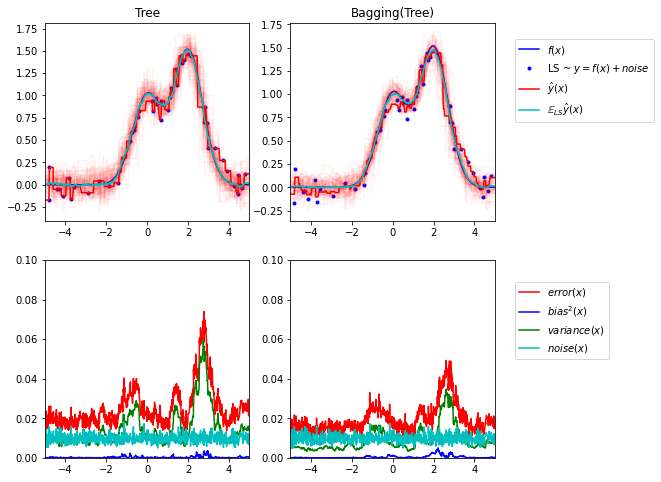

In [3]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# 설정
n_repeat = 50       # 기대값(평균값) 계산을 위한 훈련 반복 횟수
n_train = 50        # 훈련 세트 크기
n_test = 1000       # 테스트 세트 크기
noise = 0.1         # 잡음(노이즈)의 표준편차
np.random.seed(0)

# 주어진 모델의 편향과 분산을 분석하기 위해 다양한 모델을 지정할 수 있음.
# 일반적으로 결정트리, KNN 등 높은 분산을 갖는 모델에 잘 작동하지만
# 선형 모델 등 낮은 분산을 갖는 모델에 대해서는 잘 작동하지 않음.
estimators = [("Tree", DecisionTreeRegressor()),                              # 단일 모델 
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]   # 앙상블 모델

n_estimators = len(estimators)  # 2


# 데이터셋 생성
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        # 반복훈련 때마다 다른 타깃 사용 (테스트 용도)
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

# 훈련 세트
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

# 테스트 세트
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

# 그래프 그리기
plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()